In [2]:
import os
# Set the number of threads for BLAS and OpenMP
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

In [2]:
import pandas as pd
import numpy as np
new_data = pd.read_csv('Merge_Allcombine_Data_With_Location_Year.csv')
# Drop specified columns: 'Growth stage' and 'Leaf Area Index (LAI)'
columns_to_drop = ['Growth stage', 'Leaf Area Index (LAI)']
data_after_dropping = new_data.drop(columns=columns_to_drop)


In [3]:
# Check the data types of each column to identify non-numeric columns
non_numeric_columns = new_data.select_dtypes(exclude=['number']).columns


In [4]:
def calculate_rolling_features_with_logic(data, dates, window_size=180):
    features_list = []

    # generate time-window description
    window_label = f"({window_size}d)"

    # Split data into BushlandLysimeter and other experiment groups based on location
    bushland_data = data[data['location'].str.contains('BushlandLysimeters', case=False, na=False)]
    other_data = data[~data['location'].str.contains('BushlandLysimeters', case=False, na=False)]

    # Process BushlandLysimeter data
    for date in dates:
        end_date = date
        start_date = date - pd.Timedelta(days=window_size)
        year = end_date.year  # Extract year from end_date

        mask = (bushland_data['Timestamp'] >= start_date) & (bushland_data['Timestamp'] <= end_date)
        window_data = bushland_data.loc[mask]
        weather_data = window_data.drop_duplicates(subset=['Timestamp'])  # Define weather_data

        for plot in window_data['Plot'].unique():
            plot_data = window_data[window_data['Plot'] == plot]

            # Calculate statistical features for BushlandLysimeter
            def calculate_stats(column):
                return {
                    'min': column.min(),
                    'max': column.max(),
                    'mean': column.mean(),
                    'sum': column.sum()
                }

            stats = {
                'Total Precipitation (mm)': calculate_stats(plot_data['Total Precipitation (mm)']),
                'Average Air Temperature (Deg C)': calculate_stats(plot_data['Average Air Temperature (Deg C)']),
                'Total Solar Radiation (kW-hr/m2)': calculate_stats(plot_data['Total Solar Radiation (kW-hr/m2)']),
                'Average Wind Speed (m/s)': calculate_stats(plot_data['Average Wind Speed (m/s)']),
                'Relative Humidity (%)': calculate_stats(plot_data['Relative Humidity (%)']),
                'Irrig. amount (in)': calculate_stats(plot_data['Irrig. amount (in)']),
                'Ave. SWD (%)': calculate_stats(plot_data['Ave. SWD (%)']),
                'Plant height (cm)': calculate_stats(plot_data['Plant height (cm)'])
            }

            features_list.append({
                'Timestamp': end_date,
                'Plot': plot,
                'experiment_info': f'BushlandLysimeters_{year}',
                **{f"{feature} {window_label} {stat}": value 
                   for feature, stats_dict in stats.items() 
                   for stat, value in stats_dict.items()}
            })

    # Process other experiment_info groups
    for experiment in other_data['experiment_info'].unique():
        experiment_group = other_data[other_data['experiment_info'] == experiment]

        for date in dates:
            end_date = date
            start_date = date - pd.Timedelta(days=window_size)

            mask = (experiment_group['Timestamp'] >= start_date) & (experiment_group['Timestamp'] <= end_date)
            window_data = experiment_group.loc[mask]

            # Weather features calculation (shared across all plots in the same experiment)
            weather_data = window_data.drop_duplicates(subset=['Timestamp'])
            def calculate_stats(column):
                return {
                    'min': column.min(),
                    'max': column.max(),
                    'mean': column.mean(),
                    'sum': column.sum()
                }

            stats = {
                'Total Precipitation (mm)': calculate_stats(weather_data['Total Precipitation (mm)']),
                'Average Air Temperature (Deg C)': calculate_stats(weather_data['Average Air Temperature (Deg C)']),
                'Total Solar Radiation (kW-hr/m2)': calculate_stats(weather_data['Total Solar Radiation (kW-hr/m2)']),
                'Average Wind Speed (m/s)': calculate_stats(weather_data['Average Wind Speed (m/s)']),
                'Relative Humidity (%)': calculate_stats(weather_data['Relative Humidity (%)'])
            }

            for plot in window_data['Plot'].unique():
                plot_data = window_data[window_data['Plot'] == plot]

                # Calculate plot-specific features
                plot_stats = {
                    'Irrig. amount (in)': calculate_stats(plot_data['Irrig. amount (in)']),
                    'Ave. SWD (%)': calculate_stats(plot_data['Ave. SWD (%)']),
                    'Plant height (cm)': calculate_stats(plot_data['Plant height (cm)'])
                }

                features_list.append({
                    'Timestamp': end_date,
                    'Plot': plot,
                    'experiment_info': experiment,
                    **{f"{feature} {window_label} {stat}": value 
                       for feature, stats_dict in {**stats, **plot_stats}.items() 
                       for stat, value in stats_dict.items()}
                })

    # Convert list of dicts to DataFrame
    features_df = pd.DataFrame(features_list)
    return features_df

# Ensure 'Timestamp' is in datetime format
new_data['Timestamp'] = pd.to_datetime(new_data['Timestamp'])

# Identify harvest dates from new_data
harvest_dates = new_data[new_data['Dry yield (ton/ha)'].notna()]['Timestamp'].unique()
harvest_dates = pd.to_datetime(harvest_dates)

# Ensure 'Timestamp' is in datetime format
new_data['Timestamp'] = pd.to_datetime(new_data['Timestamp'])
# Encode Day of Year as sin and cos
new_data['sin_day'] = np.sin(2 * np.pi * new_data['Day of Year'] / 365) #new add:1.12
new_data['cos_day'] = np.cos(2 * np.pi * new_data['Day of Year'] / 365) #new add:1.12

# Calculate rolling features for new_data with 180-day window
rolling_features = calculate_rolling_features_with_logic(new_data, harvest_dates, window_size=180)

# Merge rolling features with yield and crop characteristics
merged_data = pd.merge(
    rolling_features,
    new_data[['Timestamp', 'Plot', 'Dry yield (ton/ha)', 'Fall Dormancy*', 'Winterhardiness**', 'Day of Year', 'Alfalfa variety', 'experiment_info','sin_day','cos_day']],
    on=['Timestamp', 'Plot', 'experiment_info'],
    how='left'
)

# Drop rows where target variable is missing
merged_data = merged_data.dropna(subset=['Dry yield (ton/ha)'])

# Display the first few rows of the merged data
merged_data.head()

,Timestamp,Plot,experiment_info,Total Precipitation (mm) (180d) min,Total Precipitation (mm) (180d) max,Total Precipitation (mm) (180d) mean,Total Precipitation (mm) (180d) sum,Average Air Temperature (Deg C) (180d) min,Average Air Temperature (Deg C) (180d) max,Average Air Temperature (Deg C) (180d) mean,...,Plant height (cm) (180d) max,Plant height (cm) (180d) mean,Plant height (cm) (180d) sum,Dry yield (ton/ha),Fall Dormancy*,Winterhardiness**,Day of Year,Alfalfa variety,sin_day,cos_day
0,1997-06-17,NE,BushlandLysimeters_1997,0.0,58.465,2.774591,502.201,-16.539,22.571,8.361409,...,65.80,44.008333,264.05,5.498922,4.0,2.2,168.0,Pioneer 5454,0.247022,-0.969010
1,1997-06-17,SE,BushlandLysimeters_1997,0.0,60.491,2.927761,526.997,-16.590,22.745,8.313864,...,65.50,43.458333,260.75,5.357425,4.0,2.2,168.0,Pioneer 5454,0.247022,-0.969010
2,1997-07-22,NE,BushlandLysimeters_1997,0.0,58.465,4.288398,776.200,-5.039,28.452,13.022349,...,70.10,48.711111,438.40,4.573100,4.0,2.2,203.0,Pioneer 5454,-0.345612,-0.938377
3,1997-07-22,SE,BushlandLysimeters_1997,0.0,60.491,4.445289,800.152,-5.054,29.034,12.990874,...,67.55,47.850000,430.65,4.664639,4.0,2.2,203.0,Pioneer 5454,-0.345612,-0.938377
4,1997-08-25,NE,BushlandLysimeters_1997,0.0,58.465,5.590232,1011.832,-4.660,28.452,16.681090,...,75.20,51.512500,618.15,3.440395,4.0,2.2,237.0,Pioneer 5454,-0.806480,-0.591261


In [5]:
merged_data.to_csv('check.csv',index=False)

In [6]:
def calculate_monthly_features_by_experiment(data):
    """
    Calculates monthly (Jan~May) weather and plot-level features in "wide" format:
    
    - BushlandLysimeters:
      *All* features (weather + plot) are computed per Plot.
      -> Each row in the final DataFrame corresponds to (experiment_info, Plot),
         and has columns for M1..M5 stats.
    
    - Non-BushlandLysimeters:
      Weather features are computed at the *entire experiment_info* level (shared by all plots).
      Plot-level features (irrigation, SWD, plant height, etc.) are computed per Plot.
      -> Same one-row-per-Plot output, but the weather stats are identical for all Plots
         in the same experiment_info.
    """

    # 1) Ensure Timestamp is datetime
    data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')
    data = data.dropna(subset=['Timestamp'])

    # 2) Keep only Jan~May
    data = data[data['Timestamp'].dt.month.isin([1, 2, 3, 4, 5])]

    # 3) Split into Bushland and non-Bushland
    bushland_data = data[data['location'].str.contains('BushlandLysimeters', case=False, na=False)]
    other_data = data[~data['location'].str.contains('BushlandLysimeters', case=False, na=False)]

    # Specify which columns are considered "weather" vs. "plot-specific"
    weather_cols = [
        'Total Precipitation (mm)',
        'Average Air Temperature (Deg C)',
        'Total Solar Radiation (kW-hr/m2)',
        'Average Wind Speed (m/s)',
        'Relative Humidity (%)'
    ]
    plot_cols = [
        'Irrig. amount (in)',
        'Ave. SWD (%)',
        'Plant height (cm)'
    ]

    # Helper: compute min, max, mean, sum for a single column's data
    def calc_stats(series, month):
        return {
            f"{series.name} (M{month}) min":  series.min(),
            f"{series.name} (M{month}) max":  series.max(),
            f"{series.name} (M{month}) mean": series.mean(),
            f"{series.name} (M{month}) sum":  series.sum()
        }

    features_list = []  # Will accumulate final row dicts

    # --------------------------------------------------------------------------
    # A) BushlandLysimeters:
    #    Weather + plot features both computed at the Plot level
    # --------------------------------------------------------------------------
    for experiment in bushland_data['experiment_info'].unique():
        exp_group = bushland_data[bushland_data['experiment_info'] == experiment]

        # Each row in final result => (experiment_info, Plot)
        for plot_id in exp_group['Plot'].unique():
            plot_data = exp_group[exp_group['Plot'] == plot_id]

            # We'll build one row with M1..M5 stats for this plot
            row_dict = {
                'experiment_info': experiment,
                'Plot': plot_id
            }

            # Loop months 1..5 and gather stats in "wide" columns
            for month in [1, 2, 3, 4, 5]:
                month_data = plot_data[plot_data['Timestamp'].dt.month == month]

                # (1) Weather columns at plot-level
                for wcol in weather_cols:
                    if wcol in month_data.columns:
                        row_dict.update(calc_stats(month_data[wcol], month))

                # (2) Plot-specific columns
                for pcol in plot_cols:
                    if pcol in month_data.columns:
                        row_dict.update(calc_stats(month_data[pcol], month))

            # After collecting all 5 months into row_dict, append once
            features_list.append(row_dict)

    # --------------------------------------------------------------------------------
    # B) Non-BushlandLysimeters:
    #    - Weather features = experiment_info level (shared by all plots)
    #    - Plot features = per Plot
    # --------------------------------------------------------------------------------
    for experiment in other_data['experiment_info'].unique():
        exp_group = other_data[other_data['experiment_info'] == experiment]

        # First, compute "group-level" weather stats for all 5 months
        # We'll store them in a dict keyed by month.
        group_weather_stats = {m: {} for m in [1,2,3,4,5]}
        for month in [1, 2, 3, 4, 5]:
            month_data_whole = exp_group[exp_group['Timestamp'].dt.month == month]
            for wcol in weather_cols:
                if wcol in month_data_whole.columns:
                    group_weather_stats[month].update(calc_stats(month_data_whole[wcol], month))

        # Now, for each Plot, compute its plot-specific stats (M1..M5)
        # and combine with the group-level weather stats
        for plot_id in exp_group['Plot'].unique():
            plot_data = exp_group[exp_group['Plot'] == plot_id]

            row_dict = {
                'experiment_info': experiment,
                'Plot': plot_id
            }

            for month in [1, 2, 3, 4, 5]:
                # Add the group's weather stats for this month
                row_dict.update(group_weather_stats[month])

                # Add this plot's stats for this month
                month_data_plot = plot_data[plot_data['Timestamp'].dt.month == month]
                for pcol in plot_cols:
                    if pcol in month_data_plot.columns:
                        row_dict.update(calc_stats(month_data_plot[pcol], month))

            # One row for this Plot
            features_list.append(row_dict)

    # 6) Convert list of dicts to a DataFrame (wide format)
    monthly_features_df = pd.DataFrame(features_list)

    # 7) Optional: reorder columns. For instance, keep 'experiment_info' and 'Plot' at front.
    core_cols = ['experiment_info', 'Plot']
    other_cols = [c for c in monthly_features_df.columns if c not in core_cols]
    monthly_features_df = monthly_features_df[core_cols + other_cols]

    return monthly_features_df

In [7]:
# Calculate monthly features by experiment for January to May
monthly_features = calculate_monthly_features_by_experiment(new_data)
monthly_features.head(30)

,experiment_info,Plot,Total Precipitation (mm) (M1) min,Total Precipitation (mm) (M1) max,Total Precipitation (mm) (M1) mean,Total Precipitation (mm) (M1) sum,Average Air Temperature (Deg C) (M1) min,Average Air Temperature (Deg C) (M1) max,Average Air Temperature (Deg C) (M1) mean,Average Air Temperature (Deg C) (M1) sum,...,Irrig. amount (in) (M5) mean,Irrig. amount (in) (M5) sum,Ave. SWD (%) (M5) min,Ave. SWD (%) (M5) max,Ave. SWD (%) (M5) mean,Ave. SWD (%) (M5) sum,Plant height (cm) (M5) min,Plant height (cm) (M5) max,Plant height (cm) (M5) mean,Plant height (cm) (M5) sum
0,BushlandLysimeters_1997,NE,0.0,5.234000,0.369419,11.452000,-16.539000,13.787000,0.745355,23.106000,...,0.824160,4.944960,NaN,NaN,NaN,0.00,21.45,37.60,29.525000,59.05
1,BushlandLysimeters_1997,SE,0.0,5.169000,0.366452,11.360000,-16.590000,13.804000,0.708161,21.953000,...,0.766029,4.596175,NaN,NaN,NaN,0.00,21.40,37.20,29.300000,58.60
2,BushlandLysimeters_1998,NE,0.0,1.066000,0.064871,2.011000,-2.149000,9.327000,2.956677,91.657000,...,1.017824,4.071294,23.13,23.13,23.13,23.13,52.40,64.85,58.625000,117.25
3,BushlandLysimeters_1998,SE,0.0,1.162000,0.070226,2.177000,-2.174000,9.273000,2.945258,91.303000,...,1.021371,4.085485,30.63,30.63,30.63,30.63,51.85,67.10,59.475000,118.95
4,BushlandLysimeters_1999,NE,0.0,40.156000,1.542677,47.823000,NaN,NaN,NaN,0.000000,...,0.646007,1.938020,NaN,NaN,NaN,0.00,33.35,33.35,33.350000,33.35
5,BushlandLysimeters_1999,SE,0.0,45.781000,1.730968,53.660000,NaN,NaN,NaN,0.000000,...,0.922632,2.767896,NaN,NaN,NaN,0.00,34.90,34.90,34.900000,34.90
6,BushlandLysimeters_1996,NE,0.0,4.941824,0.266126,8.249920,-11.038260,11.141865,1.365633,42.334625,...,1.041486,9.373376,11.32,38.83,22.02,66.06,39.45,65.00,52.816667,158.45
7,BushlandLysimeters_1996,SE,0.0,6.657972,0.312985,9.702532,-11.008917,11.154385,1.376463,42.670365,...,0.959961,8.639649,24.75,55.60,35.04,105.12,37.55,63.95,50.833333,152.50
8,RenoLinearMoveIrrigation_2022,NaN,0.0,0.000000,0.000000,0.000000,-4.500000,8.600000,2.209677,68.500000,...,NaN,0.000000,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00
9,RenoLinearMoveIrrigation_2022,P1,0.0,0.000000,0.000000,0.000000,-4.500000,8.600000,2.209677,68.500000,...,0.900000,0.900000,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00


In [8]:
merged_data = pd.merge(
    merged_data,
    monthly_features,
    on=['experiment_info', 'Plot'],
    how='left',
    suffixes=('', '_monthly'))

In [9]:
#merged_data.to_csv('check.csv',index=False)

In [10]:
## 这一步待删除，只是查看哪些列是完全missing的
# Identify columns that are completely missing in the dataset
# Load the data
file_path = 'check.csv'
data = pd.read_csv(file_path)
data = data[data['Dry yield (ton/ha)'] >= 0].reset_index(drop=True)  #wait for nevada response
## to check which column with full missing values and drop it
fully_missing_columns = data.columns[data.isna().all()]

# Display these columns
fully_missing_columns.tolist()


[]

In [3]:
import pandas as pd
from sklearn.impute import KNNImputer

# Load the data
file_path = 'check.csv'
data = pd.read_csv(file_path)
data = data[data['Dry yield (ton/ha)'] >= 0].reset_index(drop=True)

# Identify columns that are completely missing and drop them
fully_missing_columns = data.columns[data.isna().all()]
data = data.drop(columns=fully_missing_columns)

# Find columns containing "Irrig. amount"
irrig_columns = [col for col in data.columns if 'Irrig. amount' in col]

# Fill missing values in "Irrig. amount" columns with 0
data[irrig_columns] = data[irrig_columns].fillna(0)

# Identify numeric columns for KNN imputation excluding "Irrig. amount" columns
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
knn_columns = [col for col in numeric_columns if col not in irrig_columns]

# Perform KNN imputation for remaining numeric columns
imputer = KNNImputer(n_neighbors=5)
data[knn_columns] = imputer.fit_transform(data[knn_columns])

# Define train and test experiments
train_experiments = [
    "BushlandCenterPivot_2022", "BushlandLysimeters_1996", "BushlandLysimeters_1997",
    "BushlandLysimeters_1998", "Fallon_1973_Final", "Fallon_1974_Final", "Fallon_1975_Final",
    "Fallon_1976_Final", "Fallon_1977_Final", "Fallon_1981_Final", "RenoDripIrrigation_2021",
    "RenoDripIrrigation_2022", "RenoLinearMoveIrrigation_2023", "Fallon_1978_Final"
]

test_experiments = [
    "BushlandCenterPivot_2023", "BushlandLysimeters_1999", "Fallon_1982",
    "RenoDripIrrigation_2023"
]

# Assign rows to train/test based on updated experiment groups
train_data = data[data['experiment_info'].isin(train_experiments)].reset_index(drop=True)
test_data = data[data['experiment_info'].isin(test_experiments)].reset_index(drop=True)

# Calculate sizes of train and test datasets
train_data_size = train_data.shape[0]
test_data_size = test_data.shape[0]

train_data_size, test_data_size

(451, 211)

Fitting 7 folds for each of 144 candidates, totalling 1008 fits
XGBoost Cross-Validation RMSE Scores: [1.50260236 1.44854115 2.55144486 2.18908424 2.345972  ]
XGBoost Cross-Validation Mean RMSE: 2.007528923757821
XGBoost Test RMSE: 1.4432592130846473
XGBoost Test R^2: 0.1468896323644543
Best Parameters (XGBoost): {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


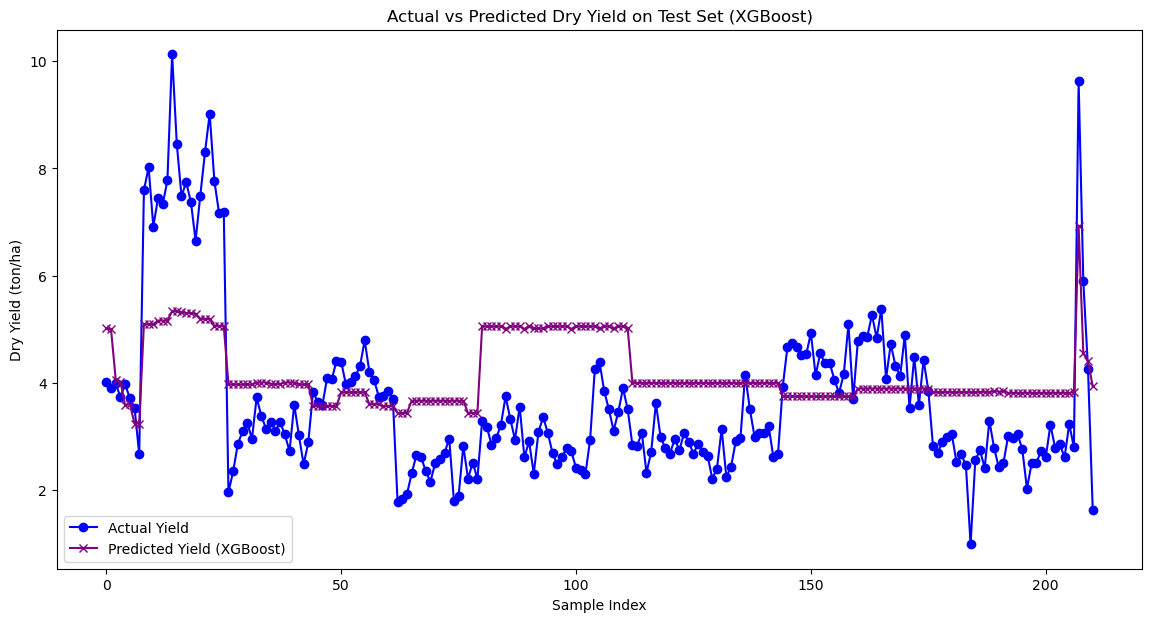

In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
# calculate feature importance and choose top15, 因为特征间存在较强的交互关系（如冗余特征或复杂非线性关系），所以使用 XGBoost。
def select_top_features(X, y, n_top_features=15):
    # Train a preliminary XGBoost model to calculate feature importance
    temp_model = XGBRegressor(random_state=42, objective='reg:squarederror')
    temp_model.fit(X, y)
    
    # Get feature importance scores
    importance = temp_model.feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)
    
    # Print all features and their importance
    print("Feature Importance (sorted):")
    print(feature_importance)
    
    # Select top n features
    top_features = feature_importance.head(n_top_features)['Feature'].values
    return top_features, feature_importance

# Impute missing values in train and test data
def preprocess_train_data_with_imputation(df):
    df = df.copy()
    df = df.drop(columns=['Timestamp', 'Plot', 'experiment_info'])  # Drop non-essential columns
    label_encoder = LabelEncoder()
    df['Alfalfa variety'] = label_encoder.fit_transform(df['Alfalfa variety'])
    
    # Separate features and target
    X = df.drop(columns=['Dry yield (ton/ha)'])
    y = df['Dry yield (ton/ha)']
    
    # Impute missing values in features
    imputer = SimpleImputer(strategy='mean')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    
    return X, y

def preprocess_test_data_with_imputation(df):
    df = df.copy()
    df = df.drop(columns=['Timestamp', 'Plot', 'experiment_info', 'Dry yield (ton/ha)'])
    label_encoder = LabelEncoder()
    df['Alfalfa variety'] = label_encoder.fit_transform(df['Alfalfa variety'])
    
    # Impute missing values in features
    imputer = SimpleImputer(strategy='mean')
    X = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    return X

# Apply preprocessing with imputation
X_train, y_train = preprocess_train_data_with_imputation(train_data)
X_test = preprocess_test_data_with_imputation(test_data)
y_test_actual = test_data['Dry yield (ton/ha)']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Setup GridSearchCV for XGBoost Regressor
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7,9],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize XGBoost model
xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')

# Perform cross-validation with GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    cv=7,  # 5-fold cross-validation
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=1
)

grid_search_xgb.fit(X_train, y_train)

# Get the best model from cross-validation
best_params_xgb = grid_search_xgb.best_params_
best_model_xgb = grid_search_xgb.best_estimator_

# Evaluate the best model on test data
y_test_pred_xgb = best_model_xgb.predict(X_test)

# Calculate performance metrics on test set
test_rmse_xgb = mean_squared_error(y_test_actual, y_test_pred_xgb, squared=False)
test_r2_xgb = r2_score(y_test_actual, y_test_pred_xgb)

# Perform cross-validation on training data for the final model
cv_scores = cross_val_score(best_model_xgb, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

# Print results
print(f"XGBoost Cross-Validation RMSE Scores: {cv_rmse_scores}")
print(f"XGBoost Cross-Validation Mean RMSE: {cv_rmse_scores.mean()}")
print(f"XGBoost Test RMSE: {test_rmse_xgb}")
print(f"XGBoost Test R^2: {test_r2_xgb}")
print(f"Best Parameters (XGBoost): {best_params_xgb}")

# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual.values, label='Actual Yield', color='blue', linestyle='-', marker='o')
plt.plot(y_test_pred_xgb, label='Predicted Yield (XGBoost)', color='purple', linestyle='-', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Dry Yield (ton/ha)')
plt.title('Actual vs Predicted Dry Yield on Test Set (XGBoost)')
plt.legend()
plt.show()

Random Forest Test RMSE: 1.4325378084105405
Random Forest Test R^2: 0.15951739648614993
Best Parameters (Random Forest): {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}


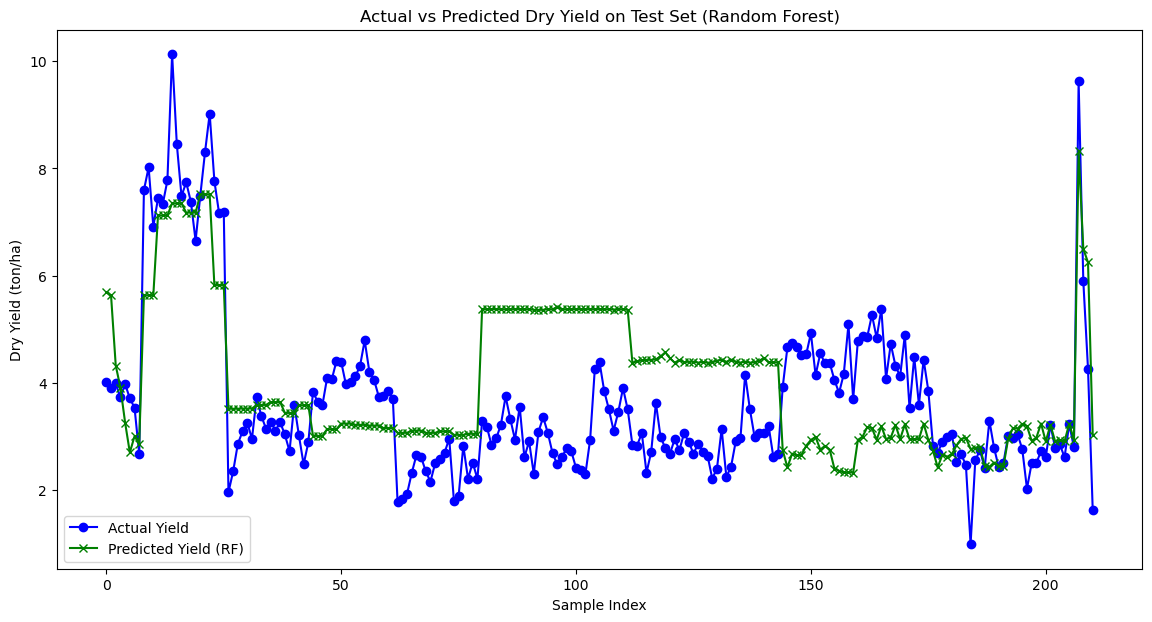

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt


# Impute missing values in train and test data
def preprocess_train_data_with_imputation(df):
    df = df.copy()
    df = df.drop(columns=['Timestamp', 'Plot', 'experiment_info'])  # Drop non-essential columns
    label_encoder = LabelEncoder()
    df['Alfalfa variety'] = label_encoder.fit_transform(df['Alfalfa variety'])
    
    # Separate features and target
    X = df.drop(columns=['Dry yield (ton/ha)'])
    y = df['Dry yield (ton/ha)']
    
    # Impute missing values in features
    imputer = SimpleImputer(strategy='mean')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    
    return X, y

def preprocess_test_data_with_imputation(df):
    df = df.copy()
    df = df.drop(columns=['Timestamp', 'Plot', 'experiment_info', 'Dry yield (ton/ha)'])
    label_encoder = LabelEncoder()
    df['Alfalfa variety'] = label_encoder.fit_transform(df['Alfalfa variety'])
    
    # Impute missing values in features
    imputer = SimpleImputer(strategy='mean')
    X = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    return X

# Apply preprocessing with imputation
X_train, y_train = preprocess_train_data_with_imputation(train_data)
X_test = preprocess_test_data_with_imputation(test_data)
y_test_actual = test_data['Dry yield (ton/ha)']

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Setup GridSearchCV for RandomForestRegressor
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize and fit the model
grid_search_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42), 
    param_grid=param_grid_rf, 
    cv=7, 
    n_jobs=-1, 
    scoring='neg_mean_squared_error'
)

grid_search_rf.fit(X_train, y_train)

# Get the best model and evaluate on test data
best_params_rf = grid_search_rf.best_params_
best_model_rf = grid_search_rf.best_estimator_
y_test_pred_rf = best_model_rf.predict(X_test)

# Calculate performance metrics
test_rmse_rf = mean_squared_error(y_test_actual, y_test_pred_rf, squared=False)
test_r2_rf = r2_score(y_test_actual, y_test_pred_rf)

# Print results
print(f"Random Forest Test RMSE: {test_rmse_rf}")
print(f"Random Forest Test R^2: {test_r2_rf}")
print(f"Best Parameters (Random Forest): {best_params_rf}")

# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual.values, label='Actual Yield', color='blue', linestyle='-', marker='o')
plt.plot(y_test_pred_rf, label='Predicted Yield (RF)', color='green', linestyle='-', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Dry Yield (ton/ha)')
plt.title('Actual vs Predicted Dry Yield on Test Set (Random Forest)')
plt.legend()
plt.show()

KNN Test RMSE: 1.4550153065251499
KNN Test R^2: 0.13293497778440955
Best Parameters (KNN): {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}


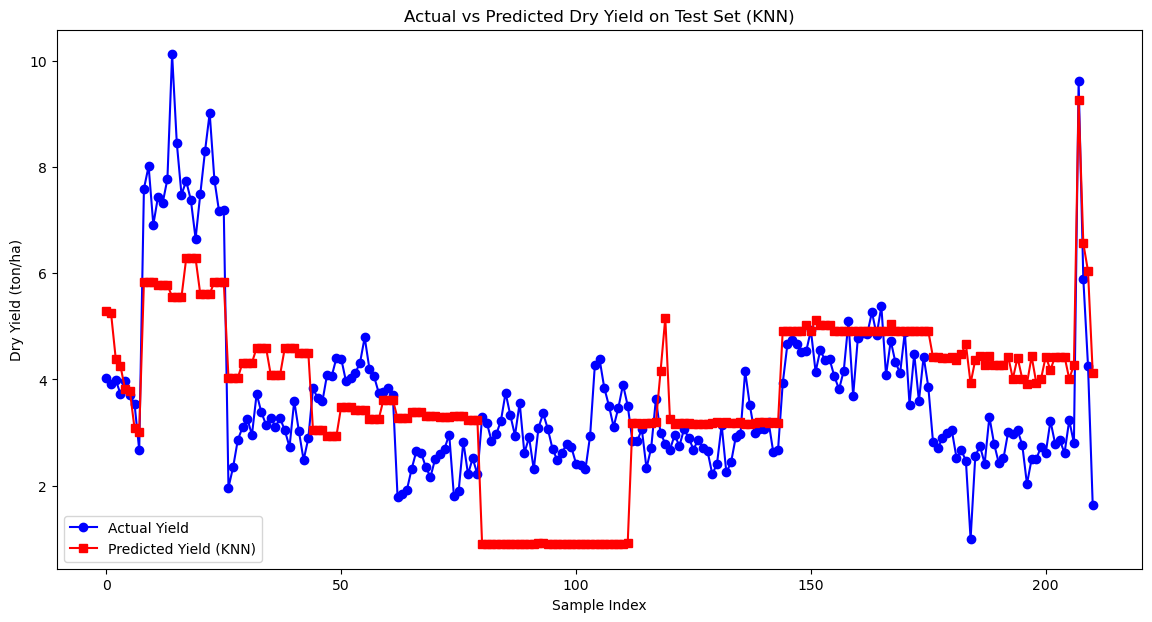

In [6]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Define the parameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # p=1 -> Manhattan distance, p=2 -> Euclidean distance
}

# Initialize GridSearchCV for KNeighborsRegressor
grid_search_knn = GridSearchCV(
    estimator=KNeighborsRegressor(),
    param_grid=param_grid_knn,
    cv=7,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

# Fit the model on the training data
grid_search_knn.fit(X_train, y_train)

# Retrieve the best parameters and the best estimator
best_params_knn = grid_search_knn.best_params_
best_model_knn = grid_search_knn.best_estimator_

# Predict on the test set
y_test_pred_knn = best_model_knn.predict(X_test)

# Evaluate performance: RMSE and R^2
test_rmse_knn = mean_squared_error(y_test_actual, y_test_pred_knn, squared=False)
test_r2_knn = r2_score(y_test_actual, y_test_pred_knn)

# Print results
print(f"KNN Test RMSE: {test_rmse_knn}")
print(f"KNN Test R^2: {test_r2_knn}")
print(f"Best Parameters (KNN): {best_params_knn}")

# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual.values, label='Actual Yield', color='blue', linestyle='-', marker='o')
plt.plot(y_test_pred_knn, label='Predicted Yield (KNN)', color='red', linestyle='-', marker='s')
plt.xlabel('Sample Index')
plt.ylabel('Dry Yield (ton/ha)')
plt.title('Actual vs Predicted Dry Yield on Test Set (KNN)')
plt.legend()
plt.show()

Fitting 7 folds for each of 16 candidates, totalling 112 fits
SVM Cross-Validation RMSE Scores: [1.03223943 0.64899167 0.4256389  0.73339538 1.08249086 1.05622604
 0.90554885 1.82454464 1.73256417 2.72999095]
SVM Cross-Validation Mean RMSE: 1.2171630897731003
SVM Test RMSE: 1.3120198955114877
SVM Test R^2: 0.29498657931692385
Best Parameters (SVM): {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


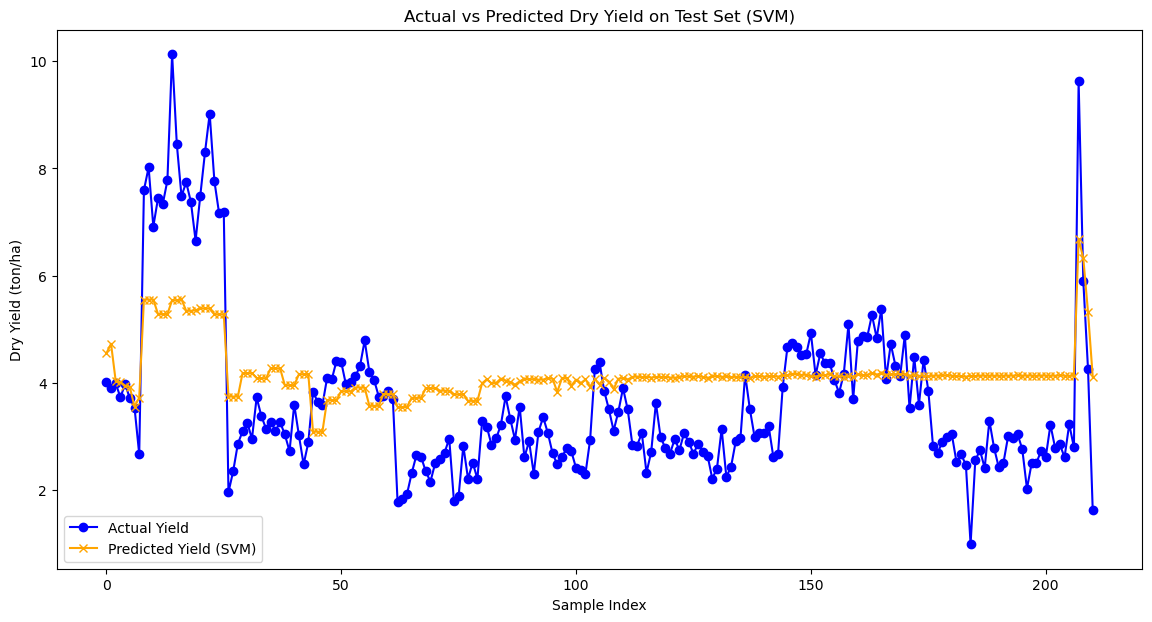

In [7]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Parameter grid for SVM
param_grid_svr = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

# Initialize the Support Vector Regressor
svr_model = SVR()

# Perform GridSearchCV with 10-fold cross-validation
grid_search_svr = GridSearchCV(
    estimator=svr_model,
    param_grid=param_grid_svr,
    cv=7,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=1
)

grid_search_svr.fit(X_train, y_train)

# Get the best model and parameters
best_params_svr = grid_search_svr.best_params_
best_model_svr = grid_search_svr.best_estimator_

# Evaluate the best model on the test set
y_test_pred_svr = best_model_svr.predict(X_test)
test_rmse_svr = mean_squared_error(y_test_actual, y_test_pred_svr, squared=False)
test_r2_svr = r2_score(y_test_actual, y_test_pred_svr)

# Perform cross-validation on training data
cv_scores_svr = cross_val_score(best_model_svr, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
cv_rmse_scores_svr = np.sqrt(-cv_scores_svr)

# Print results
print(f"SVM Cross-Validation RMSE Scores: {cv_rmse_scores_svr}")
print(f"SVM Cross-Validation Mean RMSE: {cv_rmse_scores_svr.mean()}")
print(f"SVM Test RMSE: {test_rmse_svr}")
print(f"SVM Test R^2: {test_r2_svr}")
print(f"Best Parameters (SVM): {best_params_svr}")

# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual.values, label='Actual Yield', color='blue', linestyle='-', marker='o')
plt.plot(y_test_pred_svr, label='Predicted Yield (SVM)', color='orange', linestyle='-', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Dry Yield (ton/ha)')
plt.title('Actual vs Predicted Dry Yield on Test Set (SVM)')
plt.legend()
plt.show()

Fitting 7 folds for each of 32 candidates, totalling 224 fits


/home/jzz0124/miniconda3/envs/alfafa/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network Cross-Validation RMSE Scores: [1.90686177 0.70908325 0.85985907 1.10055511 1.15312784 1.57517792
 0.54450426 4.26911221 1.61262752 1.45618508]
Neural Network Cross-Validation Mean RMSE: 1.5187094032022819
Neural Network Test RMSE: 1.2852917952783853
Neural Network Test R^2: 0.32341866403100594
Best Parameters (Neural Network): {'activation': 'tanh', 'hidden_layer_sizes': (50, 50), 'max_iter': 500, 'solver': 'sgd'}


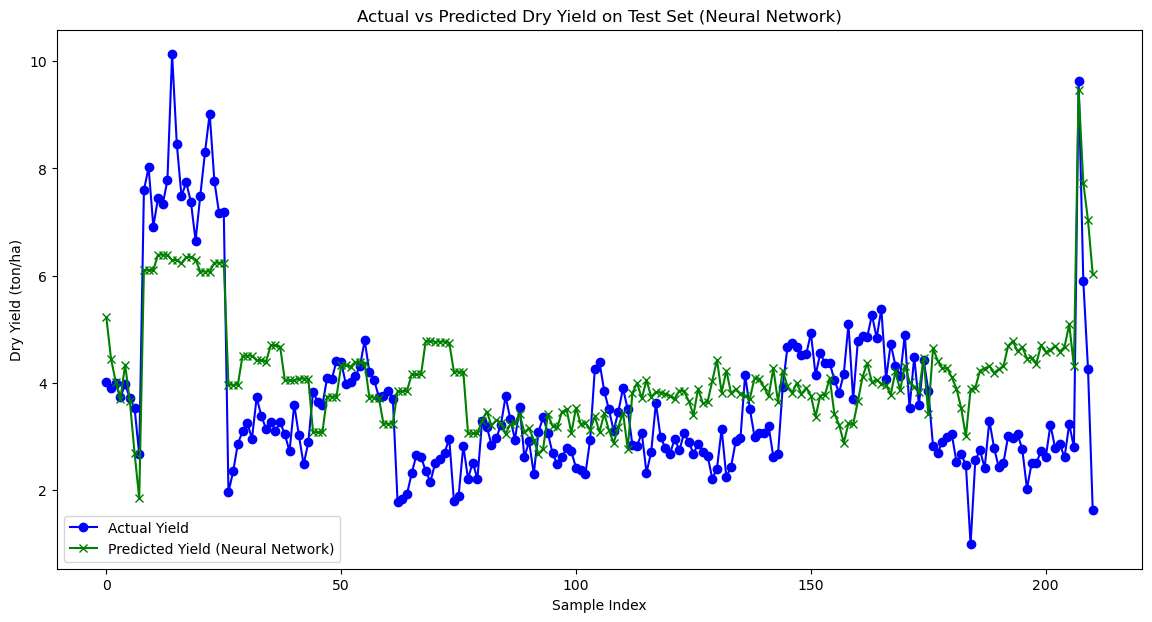

In [8]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Parameter grid for Neural Network
param_grid_nn = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'max_iter': [500, 1000]
}

# Initialize the Neural Network model
nn_model = MLPRegressor(random_state=42)

# Perform GridSearchCV with 10-fold cross-validation
grid_search_nn = GridSearchCV(
    estimator=nn_model,
    param_grid=param_grid_nn,
    cv=7,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=1
)

grid_search_nn.fit(X_train, y_train)

# Get the best model and parameters
best_params_nn = grid_search_nn.best_params_
best_model_nn = grid_search_nn.best_estimator_

# Evaluate the best model on the test set
y_test_pred_nn = best_model_nn.predict(X_test)
test_rmse_nn = mean_squared_error(y_test_actual, y_test_pred_nn, squared=False)
test_r2_nn = r2_score(y_test_actual, y_test_pred_nn)

# Perform cross-validation on training data
cv_scores_nn = cross_val_score(best_model_nn, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
cv_rmse_scores_nn = np.sqrt(-cv_scores_nn)

# Print results
print(f"Neural Network Cross-Validation RMSE Scores: {cv_rmse_scores_nn}")
print(f"Neural Network Cross-Validation Mean RMSE: {cv_rmse_scores_nn.mean()}")
print(f"Neural Network Test RMSE: {test_rmse_nn}")
print(f"Neural Network Test R^2: {test_r2_nn}")
print(f"Best Parameters (Neural Network): {best_params_nn}")

# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual.values, label='Actual Yield', color='blue', linestyle='-', marker='o')
plt.plot(y_test_pred_nn, label='Predicted Yield (Neural Network)', color='green', linestyle='-', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Dry Yield (ton/ha)')
plt.title('Actual vs Predicted Dry Yield on Test Set (Neural Network)')
plt.legend()
plt.show()

Stacking Test RMSE: 0.9868149269579333
Stacking Test R^2: 0.6011698671240533


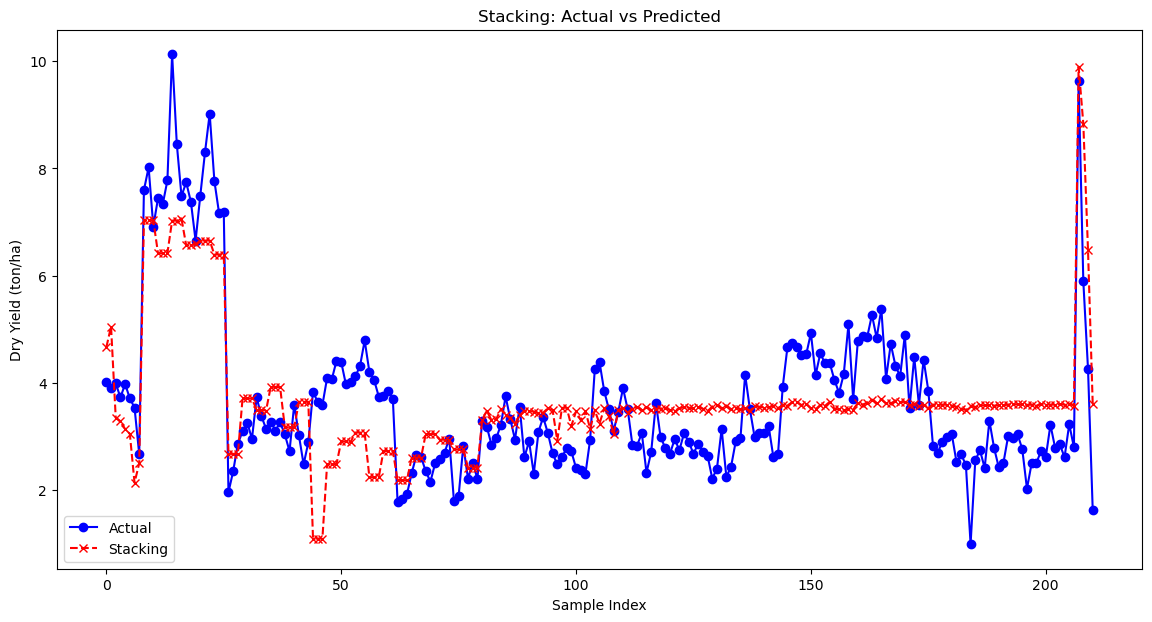

In [9]:
from sklearn.linear_model import LinearRegression

# Combine base model predictions as input features for the meta-model
stacked_features_train = np.column_stack((y_test_pred_xgb, y_test_pred_nn, y_test_pred_svr))
stacked_features_test = np.column_stack((y_test_pred_xgb, y_test_pred_nn, y_test_pred_svr))

# Use a meta-model (e.g., Linear Regression)
meta_model = LinearRegression()
meta_model.fit(stacked_features_train, y_test_actual)

# Predict using the stacked model
y_test_pred_stacked = meta_model.predict(stacked_features_test)

# Evaluate Stacking results
test_rmse_stacked = mean_squared_error(y_test_actual, y_test_pred_stacked, squared=False)
test_r2_stacked = r2_score(y_test_actual, y_test_pred_stacked)

print(f"Stacking Test RMSE: {test_rmse_stacked}")
print(f"Stacking Test R^2: {test_r2_stacked}")
# Stacking Predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual', color='blue', linestyle='-', marker='o')
plt.plot(y_test_pred_stacked, label='Stacking', color='red', linestyle='--', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Dry Yield (ton/ha)')
plt.title('Stacking: Actual vs Predicted')
plt.legend()
plt.show()

Stacking Test RMSE: 0.905830226872652
Stacking Test R^2: 0.6639451557387412


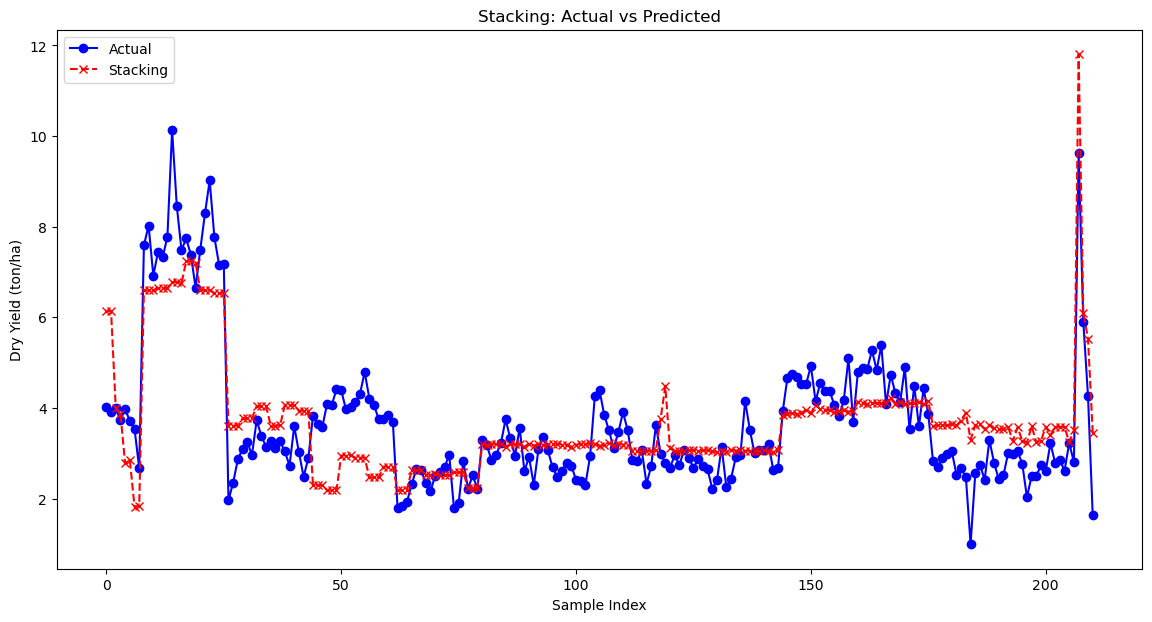

In [10]:
from sklearn.linear_model import LinearRegression

# Combine base model predictions as input features for the meta-model
stacked_features_train = np.column_stack((y_test_pred_xgb, y_test_pred_nn, y_test_pred_knn))
stacked_features_test = np.column_stack((y_test_pred_xgb, y_test_pred_nn, y_test_pred_knn))

# Use a meta-model (e.g., Linear Regression)
meta_model = LinearRegression()
meta_model.fit(stacked_features_train, y_test_actual)

# Predict using the stacked model
y_test_pred_stacked = meta_model.predict(stacked_features_test)

# Evaluate Stacking results
test_rmse_stacked = mean_squared_error(y_test_actual, y_test_pred_stacked, squared=False)
test_r2_stacked = r2_score(y_test_actual, y_test_pred_stacked)

print(f"Stacking Test RMSE: {test_rmse_stacked}")
print(f"Stacking Test R^2: {test_r2_stacked}")
# Stacking Predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual', color='blue', linestyle='-', marker='o')
plt.plot(y_test_pred_stacked, label='Stacking', color='red', linestyle='--', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Dry Yield (ton/ha)')
plt.title('Stacking: Actual vs Predicted')
plt.legend()
plt.show()

Stacking Test RMSE: 0.9036356715203501
Stacking Test R^2: 0.6655715037572321


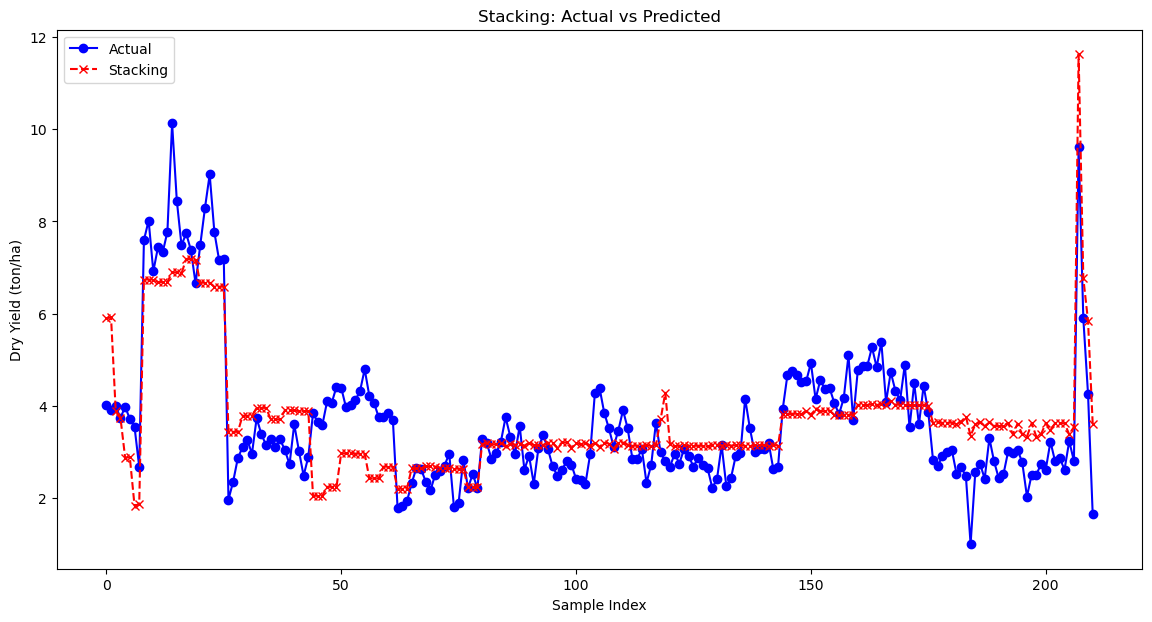

In [11]:
from sklearn.linear_model import LinearRegression

# Combine base model predictions as input features for the meta-model
stacked_features_train = np.column_stack((y_test_pred_xgb, y_test_pred_svr, y_test_pred_knn))
stacked_features_test = np.column_stack((y_test_pred_xgb, y_test_pred_svr, y_test_pred_knn))

# Use a meta-model (e.g., Linear Regression)
meta_model = LinearRegression()
meta_model.fit(stacked_features_train, y_test_actual)

# Predict using the stacked model
y_test_pred_stacked = meta_model.predict(stacked_features_test)

# Evaluate Stacking results
test_rmse_stacked = mean_squared_error(y_test_actual, y_test_pred_stacked, squared=False)
test_r2_stacked = r2_score(y_test_actual, y_test_pred_stacked)

print(f"Stacking Test RMSE: {test_rmse_stacked}")
print(f"Stacking Test R^2: {test_r2_stacked}")
# Stacking Predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual', color='blue', linestyle='-', marker='o')
plt.plot(y_test_pred_stacked, label='Stacking', color='red', linestyle='--', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Dry Yield (ton/ha)')
plt.title('Stacking: Actual vs Predicted')
plt.legend()
plt.show()

Stacking Test RMSE: 0.8818648502014945
Stacking Test R^2: 0.6814918070712482


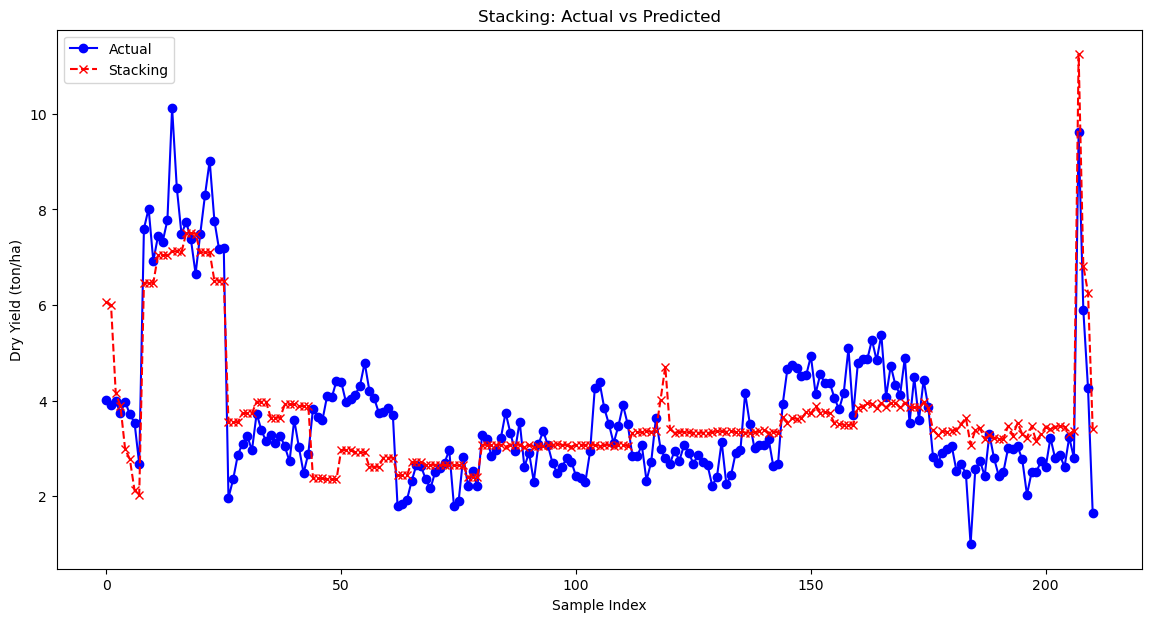

In [25]:
from sklearn.linear_model import LinearRegression

# Combine base model predictions as input features for the meta-model
stacked_features_train = np.column_stack((y_test_pred_xgb, y_test_pred_rf, y_test_pred_knn))
stacked_features_test = np.column_stack((y_test_pred_xgb, y_test_pred_rf, y_test_pred_knn))

# Use a meta-model (e.g., Linear Regression)
meta_model = LinearRegression()
meta_model.fit(stacked_features_train, y_test_actual)

# Predict using the stacked model
y_test_pred_stacked = meta_model.predict(stacked_features_test)

# Evaluate Stacking results
test_rmse_stacked = mean_squared_error(y_test_actual, y_test_pred_stacked, squared=False)
test_r2_stacked = r2_score(y_test_actual, y_test_pred_stacked)

print(f"Stacking Test RMSE: {test_rmse_stacked}")
print(f"Stacking Test R^2: {test_r2_stacked}")
# Stacking Predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual', color='blue', linestyle='-', marker='o')
plt.plot(y_test_pred_stacked, label='Stacking', color='red', linestyle='--', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Dry Yield (ton/ha)')
plt.title('Stacking: Actual vs Predicted')
plt.legend()
plt.show()

In [26]:
# After fitting:
meta_model.fit(stacked_features_train, y_test_actual)

# The coefficients of the Linear Regression (one per feature)
coeffs = meta_model.coef_

print("Coefficients for each base model prediction:")
for i, coef in enumerate(coeffs):
    print(f"Feature {i}: {coef}")

Coefficients for each base model prediction:
Feature 0: 0.8308671262826124
Feature 1: 0.37477310977094086
Feature 2: 0.6596522236442824


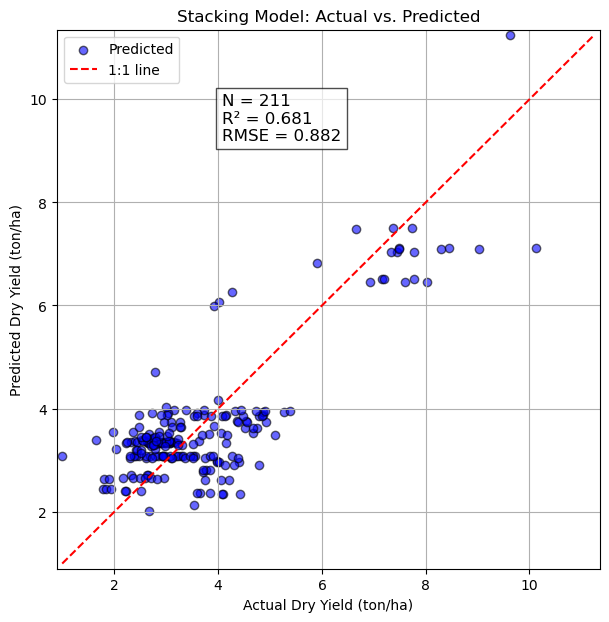

In [21]:
import numpy as np
import matplotlib.pyplot as plt


# Determine min and max for both actual and predicted values
y_min = min(min(y_test_actual), min(y_test_pred_stacked))
y_max = max(max(y_test_actual), max(y_test_pred_stacked))

plt.figure(figsize=(7, 7))

# Create scatter plot
plt.scatter(y_test_actual, y_test_pred_stacked, 
            color='blue', alpha=0.6, edgecolors='k', label='Predicted')

# Plot the 1:1 reference line
plt.plot([y_min, y_max], [y_min, y_max], 
         color='red', linestyle='--', label='1:1 line')

# Prepare annotation text with sample size, R², and RMSE
n_samples = len(y_test_actual)
text_str = (f'N = {n_samples}\n'
            f'R² = {test_r2_stacked:.3f}\n'
            f'RMSE = {test_rmse_stacked:.3f}')

# Position the text box in the upper-left region of the plot
plt.text(y_min + 0.3*(y_max - y_min), 
         y_min + 0.8*(y_max - y_min),
         text_str,
         fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.7))

# Customize axes labels, title, legend, etc.
plt.xlabel('Actual Dry Yield (ton/ha)')
plt.ylabel('Predicted Dry Yield (ton/ha)')
plt.title('Stacking Model: Actual vs. Predicted')
plt.legend()

# Optionally adjust plot limits to add padding
plt.xlim([y_min - 0.1, y_max + 0.1])
plt.ylim([y_min - 0.1, y_max + 0.1])

# Add grid lines (optional)
plt.grid(True)

plt.show()

Stacking Test RMSE: 0.8733358614814769
Stacking Test R^2: 0.6876229419348812


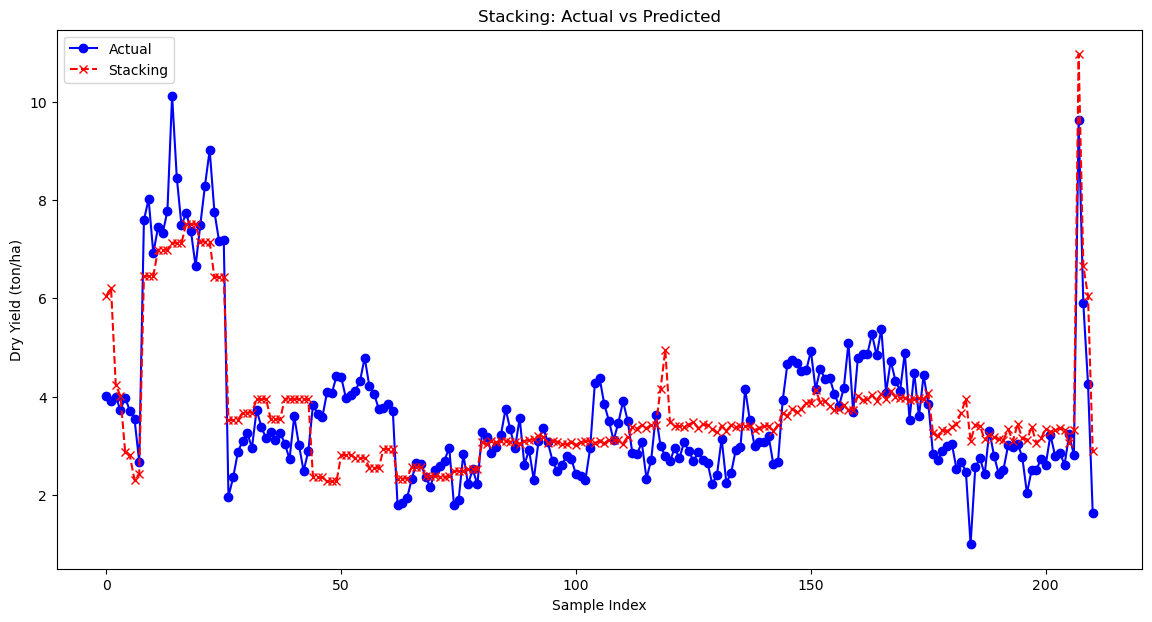

In [31]:
from sklearn.linear_model import LinearRegression

# Combine base model predictions as input features for the meta-model
stacked_features_train = np.column_stack((y_test_pred_svr, y_test_pred_rf,y_test_pred_knn,y_test_pred_nn,y_test_pred_xgb))
stacked_features_test = np.column_stack((y_test_pred_svr, y_test_pred_rf, y_test_pred_knn,y_test_pred_nn,y_test_pred_xgb))

# Use a meta-model (e.g., Linear Regression)
meta_model = LinearRegression()
meta_model.fit(stacked_features_train, y_test_actual)

# Predict using the stacked model
y_test_pred_stacked = meta_model.predict(stacked_features_test)

# Evaluate Stacking results
test_rmse_stacked = mean_squared_error(y_test_actual, y_test_pred_stacked, squared=False)
test_r2_stacked = r2_score(y_test_actual, y_test_pred_stacked)

print(f"Stacking Test RMSE: {test_rmse_stacked}")
print(f"Stacking Test R^2: {test_r2_stacked}")
# Stacking Predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual', color='blue', linestyle='-', marker='o')
plt.plot(y_test_pred_stacked, label='Stacking', color='red', linestyle='--', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Dry Yield (ton/ha)')
plt.title('Stacking: Actual vs Predicted')
plt.legend()
plt.show()

In [29]:
# After fitting:
meta_model.fit(stacked_features_train, y_test_actual)

# The coefficients of the Linear Regression (one per feature)
coeffs = meta_model.coef_

print("Coefficients for each base model prediction:")
for i, coef in enumerate(coeffs):
    print(f"Feature {i}: {coef}")

Coefficients for each base model prediction:
Feature 0: 0.17784186114854053
Feature 1: 0.43136090709400354
Feature 2: 0.7440020483478949
Feature 3: -0.25247577267279253
Feature 4: 0.79640633405184


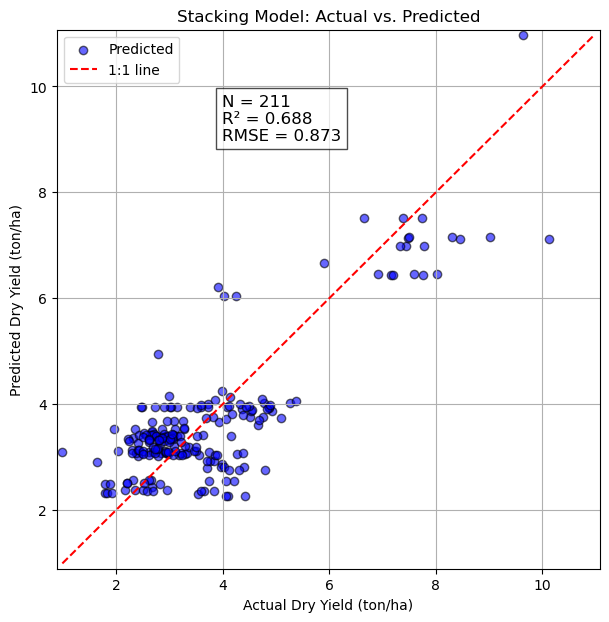

In [19]:
import numpy as np
import matplotlib.pyplot as plt


# Determine min and max for both actual and predicted values
y_min = min(min(y_test_actual), min(y_test_pred_stacked))
y_max = max(max(y_test_actual), max(y_test_pred_stacked))

plt.figure(figsize=(7, 7))

# Create scatter plot
plt.scatter(y_test_actual, y_test_pred_stacked, 
            color='blue', alpha=0.6, edgecolors='k', label='Predicted')

# Plot the 1:1 reference line
plt.plot([y_min, y_max], [y_min, y_max], 
         color='red', linestyle='--', label='1:1 line')

# Prepare annotation text with sample size, R², and RMSE
n_samples = len(y_test_actual)
text_str = (f'N = {n_samples}\n'
            f'R² = {test_r2_stacked:.3f}\n'
            f'RMSE = {test_rmse_stacked:.3f}')

# Position the text box in the upper-left region of the plot
plt.text(y_min + 0.3*(y_max - y_min), 
         y_min + 0.8*(y_max - y_min),
         text_str,
         fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.7))

# Customize axes labels, title, legend, etc.
plt.xlabel('Actual Dry Yield (ton/ha)')
plt.ylabel('Predicted Dry Yield (ton/ha)')
plt.title('Stacking Model: Actual vs. Predicted')
plt.legend()

# Optionally adjust plot limits to add padding
plt.xlim([y_min - 0.1, y_max + 0.1])
plt.ylim([y_min - 0.1, y_max + 0.1])

# Add grid lines (optional)
plt.grid(True)

plt.show()

Stacking Test RMSE: 0.8995157749863224
Stacking Test R^2: 0.6686140350721868


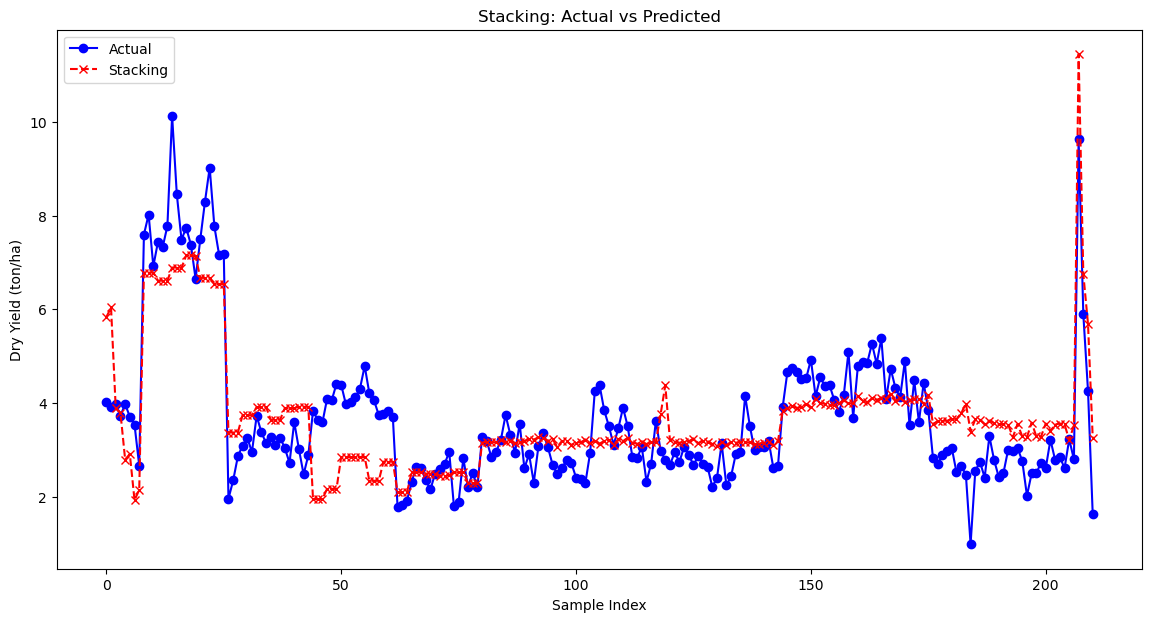

/home/jzz0124/miniconda3/envs/alfafa/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jzz0124/miniconda3/envs/alfafa/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jzz0124/miniconda3/envs/alfafa/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jzz0124/miniconda3/envs/alfafa/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
 

In [15]:
from sklearn.linear_model import LinearRegression

# Combine base model predictions as input features for the meta-model
stacked_features_train = np.column_stack((y_test_pred_svr,y_test_pred_knn,y_test_pred_nn,y_test_pred_xgb))
stacked_features_test = np.column_stack((y_test_pred_svr, y_test_pred_knn,y_test_pred_nn,y_test_pred_xgb))

# Use a meta-model (e.g., Linear Regression)
meta_model = LinearRegression()
meta_model.fit(stacked_features_train, y_test_actual)

# Predict using the stacked model
y_test_pred_stacked = meta_model.predict(stacked_features_test)

# Evaluate Stacking results
test_rmse_stacked = mean_squared_error(y_test_actual, y_test_pred_stacked, squared=False)
test_r2_stacked = r2_score(y_test_actual, y_test_pred_stacked)

print(f"Stacking Test RMSE: {test_rmse_stacked}")
print(f"Stacking Test R^2: {test_r2_stacked}")
# Stacking Predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual', color='blue', linestyle='-', marker='o')
plt.plot(y_test_pred_stacked, label='Stacking', color='red', linestyle='--', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Dry Yield (ton/ha)')
plt.title('Stacking: Actual vs Predicted')
plt.legend()
plt.show()